In [1]:
import pandas as pd
import numpy as np
from jax import random
import jax.numpy as jnp
from jax.scipy.special import expit

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.reparam import LocScaleReparam

import arviz as az

/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
numpyro.__version__

'0.9.1'

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/pyro-ppl/datasets/master/simulated_mortality.csv")
data.head()

,age_group,year,a,s1,s2,t,deaths,population
0,0,2002,0,9,0,0,0,16
1,1,2002,1,9,0,0,1,50
2,5,2002,2,9,0,0,0,33
3,10,2002,3,9,0,0,0,37
4,15,2002,4,9,0,0,0,52


In [4]:
a, s1, s2, t, deaths, population = data[["a", "s1", "s2", "t", "deaths", "population"]].to_numpy().T

In [5]:
def create_lookup(s1, s2):
    """
    Create a map between s1 indices and unique s2 indices
    """
    lookup = np.column_stack([s1, s2])
    lookup = np.unique(lookup, axis=0)
    lookup = lookup[lookup[:, 1].argsort()]
    return lookup[:, 0]
    
lookup = create_lookup(s1, s2)

In [6]:
reparam_config = {
    k: LocScaleReparam(0)
    for k in [
        "alpha_s1",
        "alpha_s2",
        "alpha_age_drift",
        "beta_age_drift",
        "pi_drift",
    ]
}

In [7]:
@numpyro.handlers.reparam(config=reparam_config)
def model(age, space, time, lookup, population, deaths=None):
    N_s1 = len(np.unique(lookup))
    N_s2 = len(np.unique(space))
    N_age = len(np.unique(age))
    N_t = len(np.unique(time))
    N = len(population)

    # plates
    age_plate = numpyro.plate("age_groups", N_age, dim=-3)
    space_plate = numpyro.plate("space", N_s2, dim=-2)
    year_plate = numpyro.plate("year", N_t - 1, dim=-1)

    # hyperparameters
    sigma_alpha_s1 = numpyro.sample("sigma_alpha_s1", dist.HalfNormal(1.0))
    sigma_alpha_s2 = numpyro.sample("sigma_alpha_s2", dist.HalfNormal(1.0))
    sigma_alpha_age = numpyro.sample("sigma_alpha_age", dist.HalfNormal(1.0))
    sigma_beta_age = numpyro.sample("sigma_beta_age", dist.HalfNormal(1.0))
    sigma_pi = numpyro.sample("sigma_pi", dist.HalfNormal(1.0))

    # spatial hierarchy
    with numpyro.plate("s1", N_s1, dim=-2):
        alpha_s1 = numpyro.sample("alpha_s1", dist.Normal(0, sigma_alpha_s1))
    with space_plate:
        alpha_s2 = numpyro.sample(
            "alpha_s2", dist.Normal(alpha_s1[lookup], sigma_alpha_s2)
        )

    # age
    with age_plate:
        alpha_age_drift_scale = jnp.pad(
            jnp.broadcast_to(sigma_alpha_age, N_age - 1),
            (1, 0),
            constant_values=10.0,  # pad so first term is alpha0, prior N(0, 10)
        )[:, jnp.newaxis, jnp.newaxis]
        alpha_age_drift = numpyro.sample(
            "alpha_age_drift", dist.Normal(0, alpha_age_drift_scale)
        )
        alpha_age = jnp.cumsum(alpha_age_drift, -3)

        beta_age_drift_scale = jnp.pad(
            jnp.broadcast_to(sigma_beta_age, N_age - 1), (1, 0), constant_values=10.0
        )[:, jnp.newaxis, jnp.newaxis]
        beta_age_drift = numpyro.sample(
            "beta_age_drift", dist.Normal(0, beta_age_drift_scale)
        )
        beta_age = jnp.cumsum(beta_age_drift, -3)
        beta_age_cum = jnp.outer(beta_age, jnp.arange(N_t))[:, jnp.newaxis, :]

    # random walk over time
    with year_plate:
        pi_drift = numpyro.sample("pi_drift", dist.Normal(0, sigma_pi))
        pi = jnp.pad(jnp.cumsum(pi_drift, -1), (1, 0))

    # likelihood
    latent_rate = alpha_age + beta_age_cum + alpha_s2 + pi
    with numpyro.plate("N", N):
        mu_logit = latent_rate[space, age, time]
        mu = numpyro.deterministic("mu", expit(mu_logit))
        numpyro.sample("deaths", dist.Binomial(population, mu), obs=deaths)


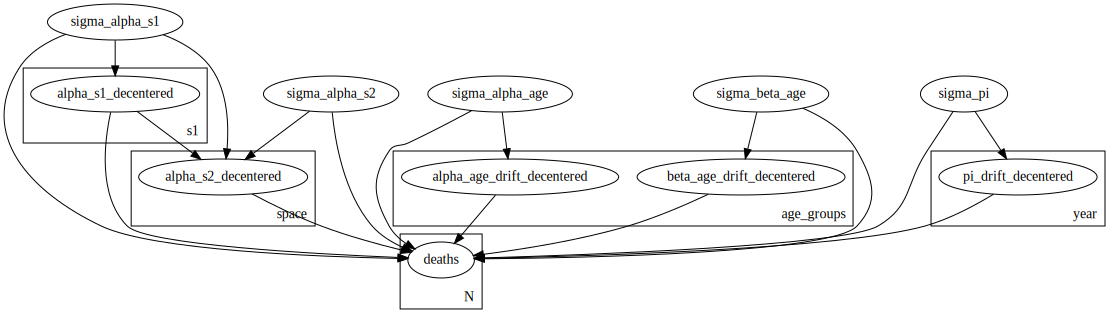

In [9]:
numpyro.render_model(
    model,
    model_args=(
        a,
        s2,
        t,
        lookup,
        population,
    )
)